<a href="https://colab.research.google.com/github/pNietoMartin/pnietomartin.github.io/blob/master/Trading5MVolumeClose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [25]:
#Get the stock quote
eur = pd.read_csv("EURUSDLong.csv",names=["Date", "Hour", "Open", "High", "Low", "Close","Volume"],delimiter=";")
print(eur[:1])
eur.shape

         Date      Hour     Open     High      Low    Close  Volume
0  2019.06.05  03:40:00  1.12632  1.12637  1.12622  1.12622     119


(100000, 7)

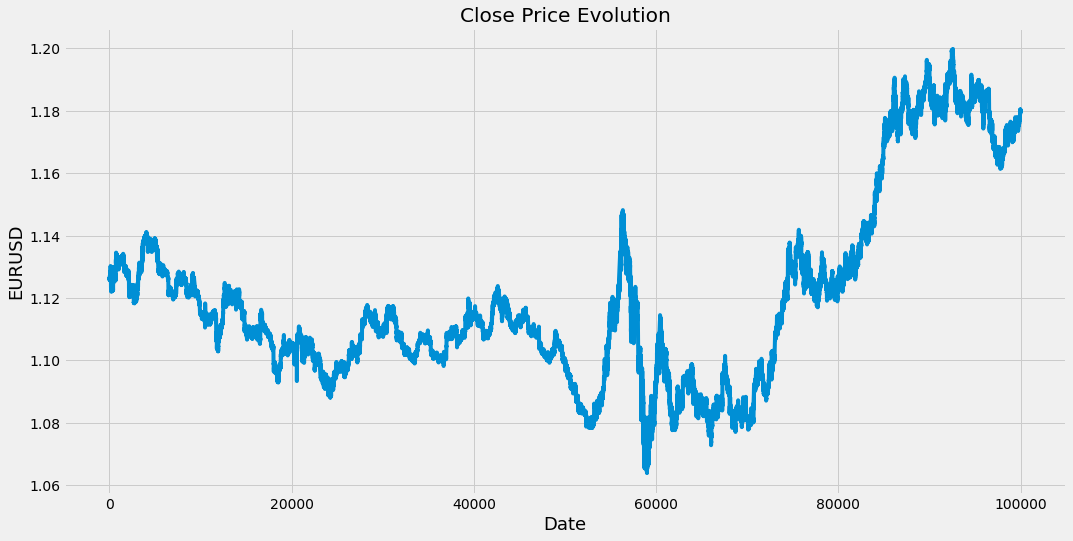

In [26]:
#Plot the stock quote
plt.figure(figsize=(16,8))
plt.title('Close Price Evolution')
plt.plot(eur['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('EURUSD',fontsize=18)
plt.show()

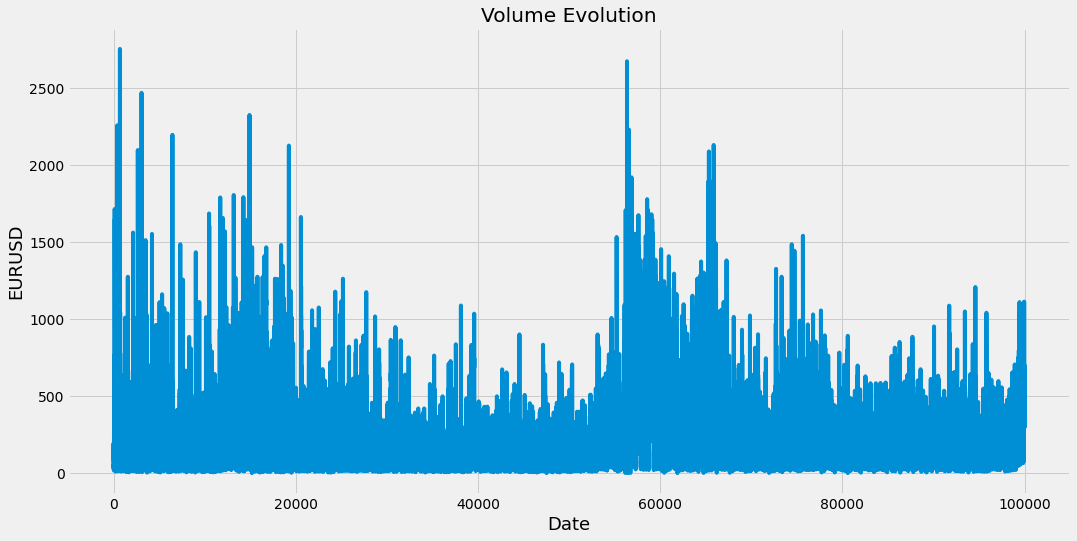

In [27]:
plt.figure(figsize=(16,8))
plt.title('Volume Evolution')
plt.plot(eur['Volume'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('EURUSD',fontsize=18)
plt.show()

In [28]:
#Filter by closing price
closePrice=eur.filter(['Close'])
volume=eur.filter(['Volume'])

In [29]:
#Identify dataset for training
dataset=closePrice.values
dataset=np.append(dataset,volume.values,axis=1)
dataset.shape

(100000, 2)

In [30]:
#Scale the data
scaler_price=MinMaxScaler(feature_range=(0,1))
scaled_data_price=scaler_price.fit_transform(dataset[:,0].reshape(-1, 1))
scaler_volume=MinMaxScaler(feature_range=(0,1))
scaled_data_volume=scaler_volume.fit_transform(dataset[:,1].reshape(-1, 1))
scaled_data = scaled_data_price
scaled_data=np.append(scaled_data,scaled_data_volume,axis=1)
scaled_data

array([[0.45857858, 0.04281567],
       [0.45622425, 0.06386067],
       [0.45762213, 0.04608128],
       ...,
       [0.850206  , 0.17343977],
       [0.85027958, 0.15638607],
       [0.85094173, 0.10849057]])

In [31]:
#Obtaining training data size 
trainingSetLength=math.ceil(len(dataset)*.7)
trainingSetLength

70000

In [32]:
#Scaling training data
trainData=scaled_data[0:trainingSetLength , :]
trainData

array([[0.45857858, 0.04281567],
       [0.45622425, 0.06386067],
       [0.45762213, 0.04608128],
       ...,
       [0.13287228, 0.03301887],
       [0.13316657, 0.02213353],
       [0.13250441, 0.04753266]])

In [33]:
#Creating input and output datasets
x_train=[]
y_train=[]

for i in range(60, len(trainData)-1):
    x_train.append(trainData[i-60:i:])
    y_train.append(trainData[i,0:1:])

In [34]:
#Transforming the input and output datasets into numpy arrays
x_train,y_train = np.array(x_train), np.array(y_train)

In [35]:
#Reshape input training data
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],2))
x_train.shape

(69939, 60, 2)

In [36]:
#Building the model
model=Sequential()
model.add ( LSTM ( 50 , return_sequences=True , input_shape = ( x_train.shape[1] , 2 ) ) )
model.add ( LSTM ( 50 , return_sequences=False ) )
model.add ( Dense(25) )
model.add ( Dense(1) )

In [37]:
#Stating the compiler of the model
model.compile (optimizer='adam',loss='mean_squared_error')

In [38]:
#Training the model
model.fit(x_train,y_train,batch_size=1, epochs=1)

69939/69939 [==============================] - 1597s 23ms/step - loss: 4.1362e-05


In [39]:
#Preparing the test set
test_data=scaled_data[trainingSetLength-60:,:]
x_test=[];
y_test = dataset [trainingSetLength:,0]
for i in range (60, len (test_data)):
    x_test.append(test_data[i-60:i:])

In [40]:
#Converting the test set into a numpy array
x_test=np.array(x_test)
x_test.shape

(30000, 60, 2)

In [41]:
#Reshape the testing input dataset
x_test = np.reshape ( x_test, ( x_test.shape[0] , x_test.shape[1], 2 ))

In [42]:
predictions = model.predict (x_test)

array([[0.13850558],
       [0.13605672],
       [0.13407284],
       ...,
       [0.8292321 ],
       [0.8275697 ],
       [0.827509  ]], dtype=float32)

In [43]:
predictions = scaler_price.inverse_transform (predictions)

array([[1.0827156],
       [1.0823828],
       [1.0821131],
       ...,
       [1.1765993],
       [1.1763734],
       [1.176365 ]], dtype=float32)

In [44]:
rmse = np.sqrt ( np.mean (predictions - y_test ) ** 2 )
rmse

0.0015680184806089066

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show>

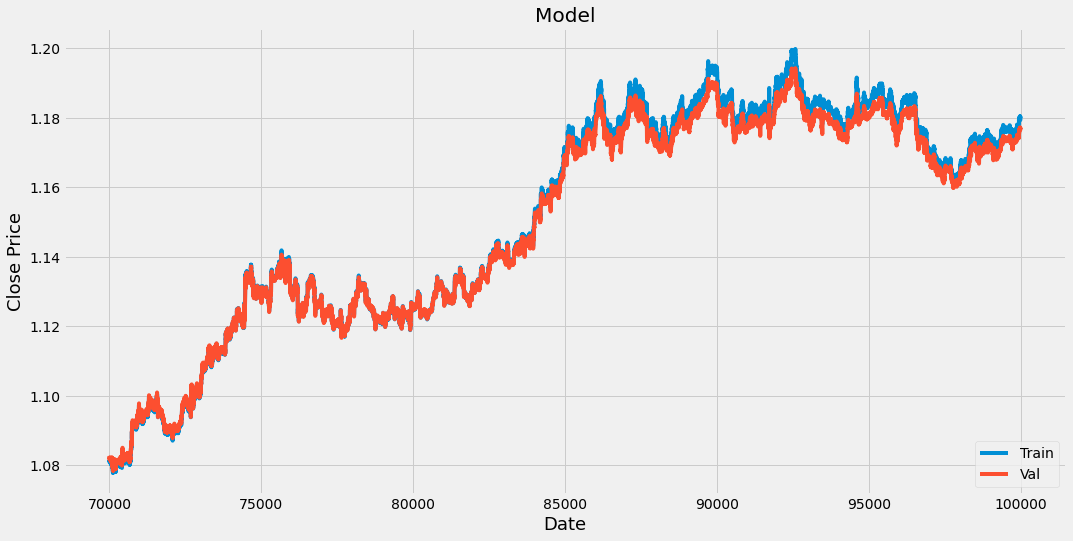

In [45]:
train = closePrice[:trainingSetLength]
valid = closePrice[trainingSetLength:]
valid.shape
valid['Predictions'] = predictions[:,0]
valid
plt.figure(figsize=(16,8))
plt.title ( 'Model' )
plt.xlabel( 'Date', fontsize = 18 )
plt.ylabel( 'Close Price', fontsize = 18 )
#plt.plot ( train ['Close'] )
plt.plot( valid )
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show

In [46]:
difference = valid['Close'] - valid['Predictions']
difference = np.mean ( np.abs(difference) )
difference

0.001779662711235045

In [49]:
newDataset = pd.read_csv(r"EURUSD.csv",sep=';',names=["Date", "Hour", "Open", "High", "Low", "Close","Volume"],skiprows = [60])
print(newDataset['Close'][59])
newData=newDataset.filter(['Close'])
volume=newDataset.filter(['Volume'])
newData=np.append(newData,volume.values,axis=1)
last60ValuesPrice=newData[-60:,0]
#print(last60ValuesPrice)
last60ValuesVolume=newData[-60:,1]
last60ValuesPriceScaled=scaler_price.fit_transform(last60ValuesPrice.reshape(-1, 1))
last60ValuesVolumeScaled=scaler_volume.fit_transform(last60ValuesVolume.reshape(-1, 1))
last60ValuesScaled=last60ValuesPriceScaled
last60ValuesScaled=np.append(last60ValuesScaled,last60ValuesVolumeScaled,axis=1)
xTestPred=[];
xTestPred.append(last60ValuesScaled)
xTestPred=np.array(xTestPred)
xTestPred = np.reshape ( xTestPred, ( xTestPred.shape[0] , xTestPred.shape[1], 2 ) )
pricePred = model.predict (xTestPred)
pricePred = scaler_price.inverse_transform (pricePred)
print(pricePred)

1.1811
[[1.180952]]
